In [1]:
%load_ext autoreload
%autoreload 2

In [148]:
#the normal stuff
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter

In [3]:
# to get JSON files from TOS API
import urllib, json
from pandas.io.json import json_normalize

In [4]:
#create a list of file names to pull each json file
from os import listdir
from os.path import isfile, join

In [5]:
# nlp imports, chose TFIDF since some words are repeated
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split

In [53]:
#nlp models
from sklearn.naive_bayes import MultinomialNB,ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Create Master DF

## Data Cleaning

All of the data for ToS;DR is stored in a directory of different json files, each labeled with a different company name. 

In [6]:
#Pull out the data 
companies = [f for f in listdir('tosdr.org/api/1/service') if isfile(join('tosdr.org/api/1/service', f))]

#try and find non-english companies to remove, looking at every letter 
#(not just first index in case non-english word appears later)

import string
ascii_chars = set(string.printable)
nonenglish = {word for word in companies for letter in word if letter not in ascii_chars}
nonenglish.remove( 'coinbase–.json')
companies = [company for company in companies if company not in nonenglish]

In [71]:
companies

['signal.json',
 'musik-sammler.json',
 'whatismyip-com.json',
 'email-cz.json',
 'upcloud.json',
 'customink.json',
 'brilliant.json',
 'pure.json',
 'zenimaxmediainc-.json',
 'qwant.json',
 'virtbiz.json',
 'any-do.json',
 'visible.json',
 'sprint.json',
 'stackoverflow.json',
 'symantec.json',
 'gitlab.json',
 'airbnb.json',
 'websaver.json',
 "mcdonald's.json",
 'kitsu.json',
 'meetup.json',
 'weebly.json',
 'pexgle.json',
 'apple.json',
 'web-de.json',
 "dr-mcdougall'shealth&medicalcenter.json",
 'newegg-com.json',
 'yelp.json',
 'carfax.json',
 'jetbrains.json',
 'diytubevideocommunity.json',
 'windowslogicproductions.json',
 'virgin.json',
 'discogs.json',
 'digitaladvertisingplatform|reklamstore.json',
 'cnn.json',
 'forbes.json',
 'npm.json',
 'w3schools.json',
 'etesync.json',
 'librarything.json',
 'wikimedia.json',
 'algolia.json',
 'imdb.json',
 'freecodecamp.json',
 'steam.json',
 'crunchyroll.json',
 'reputation.com.json',
 'coursehero.json',
 'vox.json',
 'osu!.json',
 

In [7]:
data_list = []
for company in companies:
    with open(f'tosdr.org/api/1/service/{company}') as json_data:
        data_list.append(json.load(json_data))

In [9]:
#Create main dataframe, drop unnecessary columns, expand list of lists

pd_list = []
for data in data_list:
    pd_list.append(pd.DataFrame.from_dict(data['pointsData']).T.loc[:,['id','quoteText','services','title','tosdr']])

alldata_df = pd.concat(pd_list,axis=0).reset_index()
todsr_df = json_normalize(alldata_df['tosdr'])
df = pd.concat((alldata_df,todsr_df),axis=1)
df = df.drop('tosdr',axis=1).explode('services')

In [10]:
#create master document column with tldr as base and quote text as secondar

df['document'] = df['tldr']
df['document'] = np.where(df['document'] == '',df['quoteText'],df['document'])
df['document'] = np.where(df['document'] == 'Generated through the annotate view',df['quoteText'],df['document'])
df['document'].fillna(df['quoteText'])

#if there is no text in the tldr or quoteText column, drop and reset index
df.dropna(axis=0,subset=['document'],inplace=True)
df = df.reset_index(drop=True)

In [11]:
#create labels, the point is really to distinquish "bad" language so labeled 
#both good and neutral as a success

df['label'] = df['point']
df.label = df.label.replace(['blocker','bad','neutral','good'],['bad','bad','neutral','good'])
df['binomial'] = df['point']
df.label = df.label.replace(['blocker','bad','neutral','good'],['bad','bad','neutral','good'])

In [13]:
df

,index,id,quoteText,services,title,binding,case,point,privacyRelated,score,tldr,sources,irrelevant,reason,tmp_rating,document,label
0,4411,4411,"Signal does not sell, rent or monetize your pe...",signal,This service does not sell your personal data,True,This service does not sell your personal data,good,True,25,"The terms of service state that ""Signal does n...",NaN,NaN,NaN,NaN,"The terms of service state that ""Signal does n...",good
1,4412,4412,You must be at least 13 years old to use our S...,signal,You must be at least 13 years old to use the s...,True,This service is only available to users of a c...,neutral,NaN,15,"The terms of service state: ""You must be at le...",NaN,NaN,NaN,NaN,"The terms of service state: ""You must be at le...",neutral
2,4414,4414,You agree to resolve any Claim you have with u...,signal,Court of law is in California,True,The court of law governing the terms is in loc...,neutral,NaN,0,"The terms of service state: ""You agree to reso...",NaN,NaN,NaN,NaN,"The terms of service state: ""You agree to reso...",neutral
3,4415,4415,"We may modify, suspend, or terminate your acce...",signal,The service can delete your account without pr...,True,The service can delete your account without pr...,bad,NaN,60,"The terms of service state: ""We may modify, su...",NaN,NaN,NaN,NaN,"The terms of service state: ""We may modify, su...",bad
4,4416,4416,We work with third parties to provide some of ...,signal,Third parties may be involved in operating the...,True,Third parties may be involved in operating the...,bad,NaN,15,"The privacy policy states: ""We work with third...",NaN,NaN,NaN,NaN,"The privacy policy states: ""We work with third...",bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2544,4523,4523,NaN,tos;dr,The terms for ToS;DR are easy to read,True,The terms for this service are easy to read,good,NaN,15,"Altogether, ToS and PP only make up eight line...",NaN,NaN,NaN,NaN,"Altogether, ToS and PP only make up eight line...",good
2545,4524,4524,Nothing here should be considered legal advice...,tos;dr,ToS;DR gives no guarantee regarding quality,True,This services gives no guarantee regarding qua...,bad,NaN,20,"The ToS state: ""Nothing here should be conside...",NaN,NaN,NaN,NaN,"The ToS state: ""Nothing here should be conside...",bad
2546,7679,7679,We do not use cookies or any other tracking te...,tos;dr,This service does not track you,True,This service does not track you,good,NaN,100,Generated through the annotate view,NaN,NaN,NaN,NaN,We do not use cookies or any other tracking te...,good
2547,7683,7683,By contributing to this project (e.g.\nby send...,tos;dr,"If you offer suggestions to the service, they ...",True,"If you offer suggestions to the service, they ...",good,NaN,50,Generated through the annotate view,NaN,NaN,NaN,NaN,By contributing to this project (e.g.\nby send...,good


In [14]:
#random lookup to check data

df.loc[np.random.randint(1,2564,5),['quoteText','tldr','document']]

,quoteText,tldr,document
1072,We also do not collect your IP address if you ...,Generated through the annotate view,We also do not collect your IP address if you ...
2003,NaN,Les données demeurent la propriété des utilisa...,Les données demeurent la propriété des utilisa...
1767,Warning: After you have deactivated your accou...,Generated through the annotate view,Warning: After you have deactivated your accou...
2353,"Your Privacy Rights – Effective July 9, 2018 <...",Generated through the annotate view,"Your Privacy Rights – Effective July 9, 2018 <..."
150,"For example, we collect information that you p...",Generated through the annotate view,"For example, we collect information that you p..."


In [15]:
#the land of sad documents
df.document[0],df.document[722]

('The terms of service state that "Signal does not sell, rent or monetize your personal data or content in any way – ever."',
 'Last updated: June 07, 2019')

# First Shitty Model 
### Start taking the parts of the dataframe that I want to keep

In [19]:
'''uses a method in tfidf to explore the initial clean up step - lowering 
case, removing punctuation, and splitting words'''

tfiddy = TfidfVectorizer()
tfiddy.fit(df['document'])
springcleaning = tfiddy.build_analyzer()
before = df['document'][1]
after = springcleaning(df['document'][1])
print(f'Before clean up: \n {before}\n')
print(f'After clean up: \n {after}\n')

Before clean up: 
 The terms of service state: "You must be at least 13 years old to use our Services. The minimum age to use our Services without parental approval may be higher in your home country."

After clean up: 
 ['the', 'terms', 'of', 'service', 'state', 'you', 'must', 'be', 'at', 'least', '13', 'years', 'old', 'to', 'use', 'our', 'services', 'the', 'minimum', 'age', 'to', 'use', 'our', 'services', 'without', 'parental', 'approval', 'may', 'be', 'higher', 'in', 'your', 'home', 'country']



In [20]:
'''create a list of clean companies that can be used as stop words - use 
springcleaning function to format them in a similar way to the rest of 
tfiddy
'''
dirty_companies = [company.split('.') for company in companies]
clean_companies = [springcleaning(company[0]) for company in dirty_companies]
cleanest_companies = [company for sublist in clean_companies for company in sublist]

In [21]:
cleanest_companies

['signal',
 'musik',
 'sammler',
 'whatismyip',
 'com',
 'email',
 'cz',
 'upcloud',
 'customink',
 'brilliant',
 'pure',
 'zenimaxmediainc',
 'qwant',
 'virtbiz',
 'any',
 'do',
 'visible',
 'sprint',
 'stackoverflow',
 'symantec',
 'gitlab',
 'airbnb',
 'websaver',
 'mcdonald',
 'kitsu',
 'meetup',
 'weebly',
 'pexgle',
 'apple',
 'web',
 'de',
 'dr',
 'mcdougall',
 'shealth',
 'medicalcenter',
 'newegg',
 'com',
 'yelp',
 'carfax',
 'jetbrains',
 'diytubevideocommunity',
 'windowslogicproductions',
 'virgin',
 'discogs',
 'digitaladvertisingplatform',
 'reklamstore',
 'cnn',
 'forbes',
 'npm',
 'w3schools',
 'etesync',
 'librarything',
 'wikimedia',
 'algolia',
 'imdb',
 'freecodecamp',
 'steam',
 'crunchyroll',
 'reputation',
 'coursehero',
 'vox',
 'osu',
 'nordvpn',
 'myspace',
 'tellonym',
 'goguardian',
 'quora',
 'lastpass',
 'mewe',
 'chilliapps',
 'abandonmentprotector',
 'ancestry',
 'pythonanywhere',
 'sonic',
 'net',
 'wikia',
 'allrecipes',
 'kongregate',
 'moddb',
 'com

In [22]:
X = df['document']
y = df['label']

In [23]:
X_good = df[df['point'] == 'good']['document']
X_neutral = df[df['point'] == 'neutral']['document']
X_bad = df[df['point'] == 'bad']['document']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [135]:
y_train

974         bad
2176    neutral
1098        bad
922     neutral
1778        bad
         ...   
183     neutral
1028        bad
508     neutral
2437    neutral
728     neutral
Name: label, Length: 1911, dtype: object

In [137]:
ytrain_bin = label_binarize(y_train,classes=['bad','good','neutral'])
ytest_bin = label_binarize(y_test,classes=['bad','good','neutral'])

array([[0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1]])

In [25]:
#countvoncount the countvectorizer
voncount = CountVectorizer(stop_words=cleanest_companies)
voncount.fit(X_train)
X_train_voncount = voncount.transform(X_train).toarray()
X_test_voncount = voncount.transform(X_test).toarray()

In [26]:
voncount = CountVectorizer(stop_words=cleanest_companies)
voncount_all = voncount.fit_transform(df['document']).toarray()
voncount_all.shape

(2549, 5077)

In [27]:
toswords = voncount.get_feature_names()

In [28]:
all_sum = voncount_all.sum()
good_sum = voncount_all[df['point'] == 'good'].sum()
neutral_sum = voncount_all[df['point'] == 'neutral'].sum()
bad_sum = voncount_all[df['point'] == 'bad'].sum()
print(f'Count of all words: {all_sum} \nCount of words in good documents: {good_sum}\
\nCount of words in netural documents: {neutral_sum} \nCount of words in bad documents: {bad_sum}')

Count of all words: 100436 
Count of words in good documents: 24371
Count of words in netural documents: 25654 
Count of words in bad documents: 48933


In [29]:
all_count = np.sum(voncount_all,axis=0)
good_count = np.sum(voncount_all[df['point'] =='good'],axis = 0)
neutral_count = np.sum(voncount_all[df['point'] =='neutral'],axis = 0)
bad_count = np.sum(voncount_all[df['point'] =='bad'],axis = 0)

In [30]:
#atruehonor to meet such a distinguished word

atruehonor = {}
ahonor = {}
afalsehonor = {}
alph = 1.2

for class_word_count,total_word_count,word in zip(good_count,all_count,toswords):
    atruehonor[word] = ((class_word_count**alph)/total_word_count)
for class_word_count,total_word_count,word in zip(neutral_count,all_count,toswords):
    ahonor[word] = ((class_word_count**alph)/total_word_count)
for class_word_count,total_word_count,word in zip(bad_count,all_count,toswords):
    afalsehonor[word] = ((class_word_count**alph)/total_word_count)

In [31]:
Counter(atruehonor).most_common(15)

[('days', 1.7665314390948643),
 ('want', 1.7427325876521218),
 ('ownership', 1.6996910167106056),
 ('la', 1.6952182030724354),
 ('never', 1.6785540014044966),
 ('nous', 1.6153942662021779),
 ('unsubscribe', 1.6113486821132612),
 ('delete', 1.5907632457820151),
 ('logging', 1.5848931924611134),
 ('rent', 1.5848931924611134),
 ('30', 1.5836862258314204),
 ('deleted', 1.5588992181955612),
 ('easy', 1.5518455739153594),
 ('erase', 1.5518455739153594),
 ('factor', 1.5518455739153594)]

In [32]:
Counter(ahonor).most_common(15)

[('13', 2.5561596864740617),
 ('age', 2.319414969825008),
 ('years', 2.315420595626855),
 ('2018', 2.2028611071638102),
 ('2019', 2.1117857649667533),
 ('responsible', 2.051052907200627),
 ('old', 2.0188930732512738),
 ('last', 2.0027726320280808),
 ('18', 1.9833726264391651),
 ('jurisdiction', 1.9341084497715753),
 ('updated', 1.9028694297028423),
 ('16', 1.8956420888727294),
 ('older', 1.838416287252544),
 ('california', 1.8285714285714283),
 ('children', 1.82056420302608)]

In [33]:
Counter(afalsehonor).most_common(15)

[('and', 2.701013004903969),
 ('or', 2.5074970275430384),
 ('beacons', 2.409233475252727),
 ('indemnify', 2.353391971359324),
 ('harmless', 2.3455876685050026),
 ('services', 2.297735728363006),
 ('cookies', 2.281080551985294),
 ('including', 2.28035047020096),
 ('costs', 2.244786134364092),
 ('technologies', 2.2193931289698874),
 ('damages', 2.216661358042455),
 ('of', 2.20620205407551),
 ('claims', 2.1991228900700497),
 ('expenses', 2.1954018974274896),
 ('party', 2.1865924439616062)]

In [ ]:
#tfiddy = TfidfVectorizer()
tfiddy = TfidfVectorizer(stop_words=cleanest_companies)
tfiddy.fit(X_train)
X_train_tfiddy = tfiddy.transform(X_train).toarray()
X_test_tfiddy = tfiddy.transform(X_test).toarray()

In [52]:
#Multinomial NB

tfiddy = TfidfVectorizer(stop_words=cleanest_companies,ngram_range=(2,2))
tfiddy.fit(X_train)
X_train_tfiddy = tfiddy.transform(X_train).toarray()
X_test_tfiddy = tfiddy.transform(X_test).toarray()

model = MultinomialNB(alpha=.01)
model.fit(X_train_tfiddy, y_train)
y_hat = model.predict(X_test_tfiddy)

model.score(X_test_tfiddy, y_test)

0.8087774294670846

In [114]:
X_test[:10].index

Int64Index([1308, 2302, 2257, 1625, 2367, 2436, 1737, 256, 902, 879], dtype='int64')

In [117]:
X_test[:10]

1308    These companies – our vendors – are contractua...
2302    You agree to indemnify SoundCloud from all cla...
2257    "We collect device-specific information (such ...
1625    If your use of the Services is prohibited by a...
2367    You retain all rights in, and are solely respo...
2436    Document History <p>2018, September 11th: GDPR...
1737    4.4 Law Enforcement, Legal Process and Complia...
256     Under "DISCLAIMER OF WARRANTIES", Discogs' ToS...
902      info given about what personal data they collect
879     Without these cookies, the Services that you h...
Name: document, dtype: object

In [119]:
from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

In [134]:
ytest_bin

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

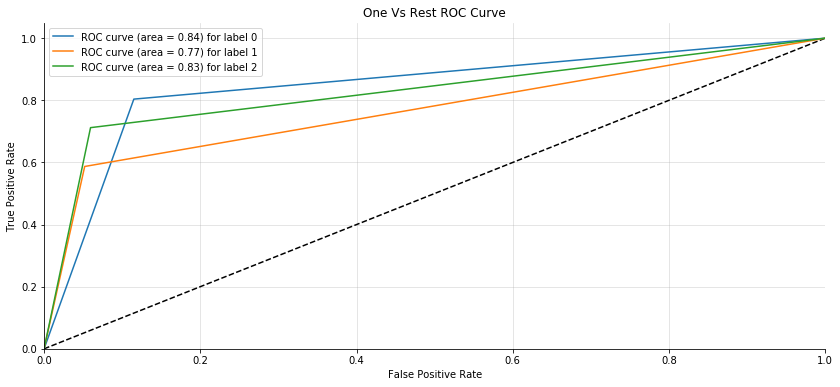

In [150]:
clf = OneVsRestClassifier(MultinomialNB(alpha=.01))
y_score = clf.fit(X_train_tfiddy,ytrain_bin).predict(X_test_tfiddy)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(ytest_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig, ax = plt.subplots(figsize=(14,6))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('One Vs Rest ROC Curve')
for i in range(3):
    ax.plot(fpr[i], tpr[i], label=f'ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
ax.legend(loc="best")
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [107]:
model.predict_proba(X_test_tfiddy)[4]

array([0.27585471, 0.59716769, 0.1269776 ])

In [112]:
y_test[:10]

1308       good
2302        bad
2257        bad
1625    neutral
2367       good
2436    neutral
1737    neutral
256         bad
902        good
879         bad
Name: label, dtype: object

In [110]:
model.predict(X_test_tfiddy)[:10]

array(['bad', 'bad', 'bad', 'neutral', 'good', 'bad', 'neutral', 'bad',
       'good', 'bad'], dtype='<U7')

In [115]:
df.iloc[[1308, 2302, 2257, 1625, 2367, 2436, 1737, 256, 902, 879]]

,index,id,quoteText,services,title,binding,case,point,privacyRelated,score,tldr,sources,irrelevant,reason,tmp_rating,document,label
1308,5819,5819,These companies – our vendors – are contractua...,vinted,Third parties used by the service are bound by...,True,Third parties used by the service are bound by...,good,NaN,20,Generated through the annotate view,NaN,NaN,NaN,NaN,These companies – our vendors – are contractua...,good
2302,629,629,"You hereby agree to indemnify, defend and hold...",soundcloud,Indemnification from claims related to your co...,True,You are solely responsible for claims made aga...,bad,NaN,40,You agree to indemnify SoundCloud from all cla...,NaN,NaN,NaN,NaN,You agree to indemnify SoundCloud from all cla...,bad
2257,1141,1141,"When you’re not signed in to a Google Account,...",google,"The service may use tracking pixels, web beaco...",True,"The service may use tracking pixels, web beaco...",bad,True,50,"""We collect device-specific information (such ...",NaN,NaN,NaN,NaN,"""We collect device-specific information (such ...",bad
1625,5180,5180,If your use of the Services is prohibited by a...,bluestacks,Users agree not to use the service for illegal...,True,Users agree not to use the service for illegal...,neutral,NaN,10,Generated through the annotate view,NaN,NaN,NaN,NaN,If your use of the Services is prohibited by a...,neutral
2367,8087,8087,"You retain all rights in, and are solely respo...",pinterest,You maintain ownership of your data,True,You maintain ownership of your data,good,NaN,50,Generated through the annotate view,NaN,NaN,NaN,NaN,"You retain all rights in, and are solely respo...",good
2436,7424,7424,"Document History <p>2018, September 11th: GDPR...",roll20,There is a date of the last update of the terms,True,There is a date of the last update of the terms,neutral,NaN,50,Generated through the annotate view,NaN,NaN,NaN,NaN,"Document History <p>2018, September 11th: GDPR...",neutral
1737,7332,7332,"4.4 Law Enforcement, Legal Process and Complia...",crowdin,This service can share your personal informati...,True,This service can share your personal informati...,neutral,NaN,0,Generated through the annotate view,NaN,NaN,NaN,NaN,"4.4 Law Enforcement, Legal Process and Complia...",neutral
256,4531,4531,"(ii) THE SERVICE WILL BE UNINTERRUPTED, TIMELY...",discogs,The service provider makes no warranty regardi...,True,The service provider makes no warranty regardi...,bad,NaN,30,"Under ""DISCLAIMER OF WARRANTIES"", Discogs' ToS...",NaN,NaN,NaN,NaN,"Under ""DISCLAIMER OF WARRANTIES"", Discogs' ToS...",bad
902,4370,4370,NaN,fwg1240,info given about what personal data they collect,True,The service provides details about what kinds ...,good,NaN,30,info given about what personal data they collect,NaN,NaN,NaN,NaN,info given about what personal data they collect,good
879,5998,5998,"Without these cookies, the Services that you h...",parsec,Blocking cookies may limit your ability to use...,True,Blocking cookies may limit your ability to use...,bad,NaN,50,Generated through the annotate view,NaN,NaN,NaN,NaN,"Without these cookies, the Services that you h...",bad


In [88]:
truegood,trueneutral,truebad,neutral_notgood,neutral_notbad,good_notneutral,good_notbad,bad_notneutral,bad_notgood = 0,0,0,0,0,0,0,0,0

for predicted,actual in zip(y_hat,y_test):
    if predicted == actual:
        if predicted == 'good':
            truegood += 1
        if predicted == 'neutral':
            trueneutral += 1
        if predicted == 'bad':
            truebad += 1
    elif (actual == 'good') & (predicted == 'neutral'):
        good_notneutral += 1
    elif (actual == 'good') & (predicted == 'bad'):
        good_notbad += 1
    elif (actual == 'neutral') & (predicted == 'good'):
        neutral_notgood += 1
    elif (actual == 'neutral') & (predicted == 'bad'):
        neutral_notbad += 1
    elif (actual == 'bad') & (predicted == 'neutral'):
        bad_notneutral += 1
    elif (actual == 'bad') & (predicted == 'good'):
        bad_notgood += 1

In [89]:
truegood,trueneutral,truebad,neutral_notgood,neutral_notbad,good_notneutral,good_notbad,bad_notneutral,bad_notgood

(98, 144, 274, 12, 28, 13, 27, 19, 23)

In [38]:
#Multinomial NB with count vectorizer instead of TFIDF

model = MultinomialNB(alpha=.01)
model.fit(X_train_voncount, y_train)
y_hat = model.predict(X_test_voncount)

model.score(X_test_voncount, y_test)

0.786833855799373

In [ ]:
#Complement NB

model = ComplementNB(alpha=.3)
model.fit(X_train_tfiddy, y_train)
y_hat = model.predict(X_test_tfiddy)

#model.predict_proba(X_test_tfiddy)
model.score(X_test_tfiddy,y_test)

In [64]:
dime = LogisticRegression(solver='lbfgs',multi_class='multinomial')
dime.fit(X_train_tfiddy,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [65]:
dime.score(X_test_tfiddy,y_test)

0.7617554858934169

In [67]:
#lostwoods = RandomForestClassifier(n_estimators=1000)
#lostwoods.fit(X_train_tfiddy,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [68]:
lostwoods.score(X_test_tfiddy,y_test)

0.7304075235109718

In [ ]:
clflost = OneVsRestClassifier(RandomForestClassifier(n_estimators=100))
ylost_score = clflost.fit(X_train_tfiddy,ytrain_bin).predict(X_test_tfiddy)

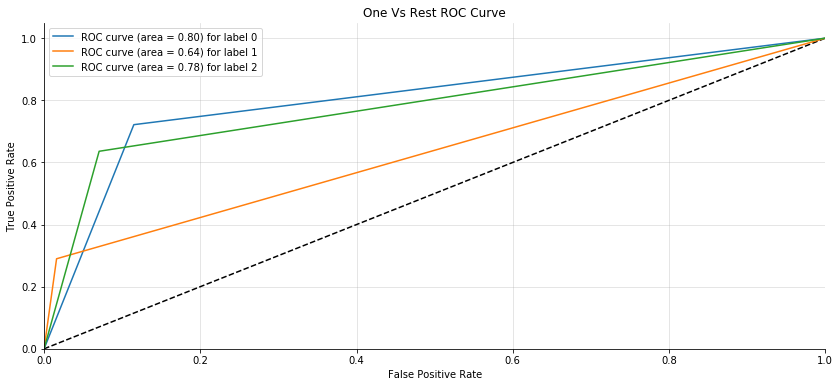

In [152]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(ytest_bin[:, i], ylost_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig, ax = plt.subplots(figsize=(14,6))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('One Vs Rest ROC Curve')
for i in range(3):
    ax.plot(fpr[i], tpr[i], label=f'ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
ax.legend(loc="best")
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [69]:
#gradientfalls = GradientBoostingClassifier(n_estimators=1000,subsample=0.5)
#gradientfalls.fit(X_train_tfiddy,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [70]:
gradientfalls.score(X_test_tfiddy,y_test)
gradientfalls.predict_

0.6974921630094044

In [45]:
feature_log_prob

NameError: name 'feature_log_prob' is not defined